In [0]:
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from scipy.stats import spearmanr

In [0]:
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, \
    log_likelihood, empirical_covariance

In [0]:
import time

In [55]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


Useful ref:

http://docs.h5py.org/en/stable/quick.html

In [0]:
prefixes = ['bc03_','fsps_','fsps_neb_','bpass_','bpass_sin_']

dusts = ['int_','dustA_', 'dustB_', 'dustC_']

listofspec = [p+d+'spec' for p in prefixes for d in dusts]

In [0]:
# Thanks to this kind soul
# https://stackoverflow.com/questions/51548551/reading-nested-h5-group-into-numpy-array

def traverse_datasets(hdf_file):

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'
            if isinstance(item, h5py.Dataset): # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group): # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    for path, _ in h5py_dataset_iterator(hdf_file):
        yield path

In [0]:
with h5py.File('My Drive/Similarity/illustris.h5', 'r') as f:
    for dset in traverse_datasets(f):
        print('Path:', dset)
        print('Shape:', f[dset].shape)
        print('Data type:', f[dset].dtype)

In [0]:
#Read in data, SFHs, stellar mass

spectra = {}

with h5py.File('My Drive/Similarity/illustris.h5','r') as f:
    spectra = {'bc03_int_spec': f['Spectra/bc03 Intrinsic/spectrum'][:], #6473 gals, 4601 wavelengths
    'bc03_dustA_spec' : f['Spectra/bc03 Dust_A/spectrum'][:], 
    'bc03_dustB_spec' : f['Spectra/bc03 Dust_B/spectrum'][:],
    'bc03_dustC_spec' : f['Spectra/bc03 Dust_C/spectrum'][:],
    'fsps_int_spec' : f['Spectra/fsps Intrinsic/spectrum'][:],
    'fsps_dustA_spec' : f['Spectra/fsps Dust_A/spectrum'][:],
    'fsps_dustB_spec' : f['Spectra/fsps Dust_B/spectrum'][:],
    'fsps_dustC_spec' : f['Spectra/fsps Dust_C/spectrum'][:],
    'fsps_neb_int_spec' : f['Spectra/fsps Intrinsic/spectrum'][:],
    'fsps_neb_dustA_spec' : f['Spectra/fsps_neb Dust_A/spectrum'][:],
    'fsps_neb_dustB_spec' : f['Spectra/fsps_neb Dust_B/spectrum'][:],
    'fsps_neb_dustC_spec' : f['Spectra/fsps_neb Dust_C/spectrum'][:],
    'bpass_int_spec' : f['Spectra/bpass Intrinsic/spectrum'][:],
    'bpass_dustA_spec' : f['Spectra/bpass Dust_A/spectrum'][:],
    'bpass_dustB_spec' : f['Spectra/bpass Dust_B/spectrum'][:],
    'bpass_dustC_spec' : f['Spectra/bpass Dust_C/spectrum'][:],
    'bpass_sin_int_spec' : f['Spectra/bpass_sin Intrinsic/spectrum'][:],
    'bpass_sin_dustA_spec' : f['Spectra/bpass_sin Dust_A/spectrum'][:],
    'bpass_sin_dustB_spec' : f['Spectra/bpass_sin Dust_B/spectrum'][:],
    'bpass_sin_dustC_spec' : f['Spectra/bpass_sin Dust_C/spectrum'][:]}
    
    wl = f['Spectra/bc03 Dust_A/wavelength'][:]

    SFHs = f['SFH/log_8'][:]

    SMass = f['/Subhalos/Stellar Mass'][:]

    binlimits = f['/bins/log_8/binLimits'][:] 


In [0]:
ref_spec = spectra['fsps_dustB_spec']

Let's log those spectra

In [0]:
X = np.log10(ref_spec)

In [0]:
X.shape

(6473, 4601)

In [0]:
np.random.seed(10)

sel = np.random.choice(X.shape[0], 650)
#make it smaller

In [0]:
model = RandomForestRegressor()

In [0]:
cv = KFold(shuffle = True, n_splits=5)

In [0]:
target0 = SFHs[sel,0] #look at most recent bin

In [0]:
def smape(true,pred):
  return 2 * np.sum(np.abs(true-pred))/np.sum(true+pred)

In [0]:
smape_scorer = make_scorer(smape, greater_is_better = False)

In [0]:
#Every 2 features

scores = cross_validate(model, X[sel,::2], target0, cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)

print(scores)

print(scores['test_score'].mean(),scores['test_score'].std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  43.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.8s remaining:    0.0s


[CV] ................................................. , total=  43.8s
[CV]  ................................................................
[CV] ................................................. , total=  45.0s
[CV]  ................................................................
[CV] ................................................. , total=  44.7s
[CV]  ................................................................
[CV] ................................................. , total=  45.0s
{'fit_time': array([43.73545361, 43.77424574, 45.03991771, 44.71086645, 45.00603628]), 'score_time': array([0.01087737, 0.01034665, 0.00937676, 0.00991583, 0.00970984]), 'test_score': array([-0.28615163, -0.27768861, -0.2913394 , -0.2308549 , -0.26957338]), 'train_score': array([-0.1019439 , -0.10540736, -0.10127746, -0.11045581, -0.09994259])}
-0.27112158271349257 0.021455027836370367


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished


In [0]:
print(scores['test_score'].mean(),scores['test_score'].std())
print(scores['train_score'].mean(),scores['train_score'].std())

-0.27112158271349257 0.021455027836370367
-0.10380542574210465 0.003783416793186504


In [0]:
scores

{'fit_time': array([43.73545361, 43.77424574, 45.03991771, 44.71086645, 45.00603628]),
 'score_time': array([0.01087737, 0.01034665, 0.00937676, 0.00991583, 0.00970984]),
 'test_score': array([-0.28615163, -0.27768861, -0.2913394 , -0.2308549 , -0.26957338]),
 'train_score': array([-0.1019439 , -0.10540736, -0.10127746, -0.11045581, -0.09994259])}

In [0]:
#no need to run

ypred = cross_val_predict(model, X[sel,::2], target0, cv = cv)

Compare predicted and true

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


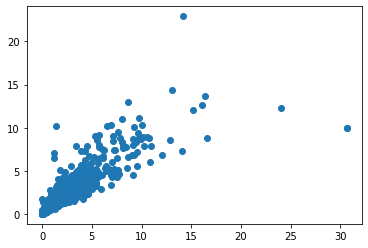

In [0]:
plt.scatter(target0, ypred)

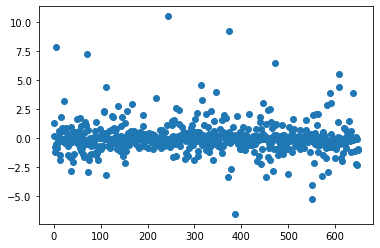

In [0]:
plt.scatter(range(len(target0)),target0-ypred)

In [0]:
def transf_target(target):
  return np.log(target + 5)

def inv_transf_target(x):
  return np.exp(x)-5

To compare the smapes of the two methods I need predictions, so I will have 5 random folds and compute metrics.

In [0]:
r2 = []
smapesss = []
mae = []
Spearmans = []

est_names = ['r2','smapesss','mae','Spearman']

for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(X[sel,::2], transf_target(target0), test_size=0.2, random_state = i)
  model.fit(X_train,y_train)
  ypred = model.predict(X_test)
  print('r2', metrics.r2_score(inv_transf_target(y_test),inv_transf_target(ypred)))
  r2.append(metrics.r2_score(inv_transf_target(y_test),inv_transf_target(ypred)))
  print('smape', smape(inv_transf_target(y_test),inv_transf_target(ypred)))
  smapesss.append(smape(inv_transf_target(y_test),inv_transf_target(ypred)))
  print('mae', metrics.median_absolute_error(inv_transf_target(y_test),inv_transf_target(ypred)))
  mae.append(metrics.median_absolute_error(inv_transf_target(y_test),inv_transf_target(ypred)))
  print('Spearman', spearmanr(inv_transf_target(y_test),inv_transf_target(ypred)))
  Spearmans.append(spearmanr(inv_transf_target(y_test),inv_transf_target(ypred))[0])

for i, estimator in enumerate([r2,smapesss,mae,Spearmans]):
  print(est_names[i], np.array(estimator).mean(), np.array(estimator).std())

r2 0.7597563201974709
smape 0.2948074076089532
mae 0.4734038203424449
Spearman SpearmanrResult(correlation=0.912429946368404, pvalue=1.655203968112446e-51)
r2 0.5946383957703167
smape 0.31090748405676955
mae 0.3016270961019738
Spearman SpearmanrResult(correlation=0.8906358252049011, pvalue=1.2241363130117922e-45)
r2 0.8155573304584243
smape 0.259162681770058
mae 0.3933401013656965
Spearman SpearmanrResult(correlation=0.9334615199011166, pvalue=7.568969665098738e-59)
r2 0.7973155563622216
smape 0.30289166091517805
mae 0.37097784639809905
Spearman SpearmanrResult(correlation=0.924771646427607, pvalue=1.4776710594223913e-55)
r2 0.7686946299672497
smape 0.27191767072357836
mae 0.3985686375239439
Spearman SpearmanrResult(correlation=0.9390088070052249, pvalue=3.4401112007678526e-61)


AttributeError: ignored

In [0]:
for i, estimator in enumerate([r2,smapesss,mae]):
  print(est_names[i], np.array(estimator).mean(), np.array(estimator).std())
tot=0
for i in range(5):
  tot +=Spearmans[i][0]
print('Spearmans mean', tot/5)

r2 0.7471924465511366 0.07884036619789281
smapesss 0.28793738101490746 0.019406534059135592
mae 0.38758350034643163 0.055105698783356874
Spearmans mean 0.9200615489814506


In [0]:
#Now without transformation

r2 = []
smapesss = []
mae = []
Spearmans = []

est_names = ['r2','smapesss','mae','Spearman']

for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(X[sel,::2], target0, test_size=0.2, random_state = i)
  model.fit(X_train,y_train)
  ypred = model.predict(X_test)
  print('r2', metrics.r2_score(y_test,ypred))
  r2.append(metrics.r2_score((y_test),(ypred)))
  print('smape', smape(y_test,ypred))
  smapesss.append(smape(y_test,ypred))
  print('mae', metrics.median_absolute_error(y_test,ypred))
  mae.append(metrics.median_absolute_error(y_test,ypred))
  print('Spearman', spearmanr(y_test,ypred))
  Spearmans.append(spearmanr(y_test,ypred)[0])

for i, estimator in enumerate([r2,smapesss,mae,Spearmans]):
  print(est_names[i], np.array(estimator).mean(), np.array(estimator).std())

r2 0.7201342179014201
smape 0.29641151403664645
mae 0.48881702336011723
Spearman SpearmanrResult(correlation=0.9053823834193208, pvalue=1.8663310176695177e-49)
r2 0.5490176444788297
smape 0.3109214831723234
mae 0.25599598789073286
Spearman SpearmanrResult(correlation=0.889412124183961, pvalue=2.3971513623406144e-45)
r2 0.676121362158443
smape 0.3067710783851146
mae 0.4154756560743017
Spearman SpearmanrResult(correlation=0.932887959401195, pvalue=1.2871133493157625e-58)
r2 0.8693665959919483
smape 0.2750778556848347
mae 0.3858399020277756
Spearman SpearmanrResult(correlation=0.9283068566235245, pvalue=7.605050819132784e-57)
r2 0.766326013257102
smape 0.2690992960462335
mae 0.4135691011039409
Spearman SpearmanrResult(correlation=0.9367635310837352, pvalue=3.237585801006345e-60)
r2 0.7161931667575486 0.10539861325338526
smapesss 0.29165624546503055 0.016768298137229198
mae 0.39193953409137366 0.07605904075003703
Spearman 0.9185505709423474 0.01819289958944056


To keep in mind: transformation helps just a little, but let's keep it aside for the time being.

Let's check the effect of feature selection, with Select from Model and then Feature Importance (should be the same!)

In [0]:
piped_model = make_pipeline(SelectFromModel(RandomForestRegressor(), max_features = 50, threshold=-np.inf), RandomForestRegressor()) #

In [0]:
cv = 

KFold(n_splits=5, random_state=None, shuffle=True)

In [0]:
#with simple every two Feature Selection

cv_scores = cross_validate(piped_model, X[sel,::2], target0, cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  44.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.0s remaining:    0.0s


[CV] ................................................. , total=  46.3s
[CV]  ................................................................
[CV] ................................................. , total=  46.1s
[CV]  ................................................................
[CV] ................................................. , total=  46.0s
[CV]  ................................................................
[CV] ................................................. , total=  46.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished


In [0]:
cv_scores['test_score'].mean(), cv_scores['test_score'].std()

(-0.27516906294982524, 0.013337450796974584)

In [0]:
ntrials=5

glob_imp = np.zeros(X[sel,::2].shape[1])

model = RandomForestRegressor()

for i in range(ntrials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X[sel,::2], target0, test_size=0.2, random_state=i) 
        model.fit(X[sel,::2], target0)
        importances = model.feature_importances_
        glob_imp+=importances
        
indices = np.argsort(glob_imp)[::-1]

        # Print the feature ranking
print("Feature ranking:")

for f in range(50):
    print("%d. feature: %d (%f)" % (f + 1, indices[f], glob_imp[indices[f]]/ntrials))

       

Feature ranking:
1. feature: 269 (0.440842)
2. feature: 268 (0.112167)
3. feature: 270 (0.064836)
4. feature: 267 (0.019797)
5. feature: 266 (0.008874)
6. feature: 2221 (0.005886)
7. feature: 271 (0.004881)
8. feature: 293 (0.003411)
9. feature: 2278 (0.002976)
10. feature: 468 (0.002423)
11. feature: 134 (0.002063)
12. feature: 461 (0.002045)
13. feature: 228 (0.001899)
14. feature: 367 (0.001741)
15. feature: 292 (0.001719)
16. feature: 225 (0.001673)
17. feature: 173 (0.001667)
18. feature: 273 (0.001644)
19. feature: 280 (0.001638)
20. feature: 294 (0.001451)
21. feature: 192 (0.001445)
22. feature: 210 (0.001444)
23. feature: 633 (0.001441)
24. feature: 108 (0.001431)
25. feature: 101 (0.001397)
26. feature: 220 (0.001380)
27. feature: 265 (0.001375)
28. feature: 230 (0.001331)
29. feature: 1046 (0.001326)
30. feature: 2287 (0.001319)
31. feature: 10 (0.001292)
32. feature: 216 (0.001289)
33. feature: 194 (0.001288)
34. feature: 143 (0.001236)
35. feature: 229 (0.001105)
36. featu

In [0]:
indices

array([ 269,  268,  270, ..., 1514, 2044, 1387])

In [0]:
glob_imp

array([0.00215957, 0.00261358, 0.00207004, ..., 0.00211052, 0.00158774,
       0.00310904])

In [0]:
for f in range(50):
    print("%d. feature: %d (%f)" % (f + 1, indices[f], glob_imp[indices[f]]/ntrials))

1. feature: 269 (0.440842)
2. feature: 268 (0.112167)
3. feature: 270 (0.064836)
4. feature: 267 (0.019797)
5. feature: 266 (0.008874)
6. feature: 2221 (0.005886)
7. feature: 271 (0.004881)
8. feature: 293 (0.003411)
9. feature: 2278 (0.002976)
10. feature: 468 (0.002423)
11. feature: 134 (0.002063)
12. feature: 461 (0.002045)
13. feature: 228 (0.001899)
14. feature: 367 (0.001741)
15. feature: 292 (0.001719)
16. feature: 225 (0.001673)
17. feature: 173 (0.001667)
18. feature: 273 (0.001644)
19. feature: 280 (0.001638)
20. feature: 294 (0.001451)
21. feature: 192 (0.001445)
22. feature: 210 (0.001444)
23. feature: 633 (0.001441)
24. feature: 108 (0.001431)
25. feature: 101 (0.001397)
26. feature: 220 (0.001380)
27. feature: 265 (0.001375)
28. feature: 230 (0.001331)
29. feature: 1046 (0.001326)
30. feature: 2287 (0.001319)
31. feature: 10 (0.001292)
32. feature: 216 (0.001289)
33. feature: 194 (0.001288)
34. feature: 143 (0.001236)
35. feature: 229 (0.001105)
36. feature: 321 (0.001067

In [0]:
wl[::2][269], wl[538], wl[539]

(3935.0822725535713, 3935.0822725535713, 3935.79040331016)

Note that the selection is from X[::2]!

In [0]:
Xsel = X[sel,::2]
Xnew = Xsel[:,indices[:50]]

In [57]:
#With 50 features

n_scores = cross_validate(model, Xnew, target0, cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)

print(n_scores)
 
print(n_scores['test_score'].mean(),n_scores['test_score'].std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   1.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ................................................. , total=   1.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.2s
{'fit_time': array([1.17316127, 1.14863443, 1.16237903, 1.15629816, 1.16217375]), 'score_time': array([0.00847125, 0.00833416, 0.00782871, 0.00758266, 0.00763965]), 'test_score': array([-0.28601789, -0.28249371, -0.23494847, -0.23532153, -0.27275546]), 'train_score': array([-0.10069973, -0.10149508, -0.09979983, -0.09857185, -0.10466024])}
-0.2623074147508231 0.02260789374369261


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s finished


Scores are good, let's keep going.

In [0]:
 #tiny parameter optimization 

In [59]:
parameters = {'max_depth':[10,20,40], \
              'max_features': [0.5,1.0], 'n_estimators':[100,200,400]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = smape_scorer, return_train_score = True, \
    verbose = 3, n_jobs = 4)
model.fit(Xnew, target0)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  2.6min finished


Best params, best score: -0.2521 {'max_depth': 20, 'max_features': 0.5, 'n_estimators': 400}


In [60]:
scores_lim = pd.DataFrame(model.cv_results_)
scores_lim[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

,params,mean_test_score,std_test_score,mean_train_score
8,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 400}",-0.252059,0.020592,-0.097714
15,"{'max_depth': 40, 'max_features': 1.0, 'n_estimators': 100}",-0.253026,0.020337,-0.098325
7,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 200}",-0.253349,0.015237,-0.098013
6,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 100}",-0.253702,0.016372,-0.098110
17,"{'max_depth': 40, 'max_features': 1.0, 'n_estimators': 400}",-0.254051,0.017408,-0.097766
11,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 400}",-0.254600,0.017772,-0.098531
13,"{'max_depth': 40, 'max_features': 0.5, 'n_estimators': 200}",-0.255171,0.020439,-0.099018
14,"{'max_depth': 40, 'max_features': 0.5, 'n_estimators': 400}",-0.255219,0.017347,-0.098026
10,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 200}",-0.255306,0.020494,-0.097983
16,"{'max_depth': 40, 'max_features': 1.0, 'n_estimators': 200}",-0.255648,0.017910,-0.098175


In [0]:
bestmodel = RandomForestRegressor(n_estimators=200, max_depth=20)

In [0]:
Xlarge = X[:,::2]
Xlarge_lim = Xlarge[:,indices[:50]]

In [64]:
Xlarge_lim.shape

(6473, 50)

Scores on all samples

In [67]:
#Every 2 features

scores = cross_validate(bestmodel, Xlarge_lim, SFHs[:,0], cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)

print(scores)

print(scores['test_score'].mean(),scores['test_score'].std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  35.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.2s remaining:    0.0s


[CV] ................................................. , total=  35.5s
[CV]  ................................................................
[CV] ................................................. , total=  35.2s
[CV]  ................................................................
[CV] ................................................. , total=  35.0s
[CV]  ................................................................
[CV] ................................................. , total=  35.1s
{'fit_time': array([34.91129684, 35.42771316, 35.08510184, 34.87567472, 35.07678771]), 'score_time': array([0.07936096, 0.07460833, 0.07459569, 0.07767653, 0.07278252]), 'test_score': array([-0.23502701, -0.21745783, -0.22964988, -0.22290016, -0.22152208]), 'train_score': array([-0.08238643, -0.08401378, -0.08281753, -0.08306576, -0.0834041 ])}
-0.22531139375746667 0.006246069805248905


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [68]:
bestmodel.fit(Xlarge_lim, SFHs[:,0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
smapes = []

for key in spectra.keys():
  print(key)
  spec = spectra[key]
  Xt = np.log10(spec[:,::2])
  Xt = Xt[:,indices[:50]]
  SFHpred = bestmodel.predict(Xt)
  smapes.append(smape(SFHs[:,0],SFHpred))
  print(smape(SFHs[:,0],SFHpred))
a = np.array(smapes)

bc03_int_spec
0.8100184059777513
bc03_dustA_spec
0.4078190696509394
bc03_dustB_spec
0.387895914120054
bc03_dustC_spec
0.3757280347593459
fsps_int_spec
0.5961256690102394
fsps_dustA_spec
0.2111704406299009
fsps_dustB_spec
0.08146568365693593
fsps_dustC_spec
0.2035207454266625
fsps_neb_int_spec
0.5961256690102394
fsps_neb_dustA_spec
0.24009228492412393
fsps_neb_dustB_spec
0.22167813891182517
fsps_neb_dustC_spec
0.2194355725847595
bpass_int_spec
0.5055594565609838
bpass_dustA_spec
0.32628866315026617
bpass_dustB_spec
0.38350873446511263
bpass_dustC_spec
0.4270812986965034
bpass_sin_int_spec
0.3762807598701506
bpass_sin_dustA_spec
0.5592818656162508
bpass_sin_dustB_spec
0.672484980812782
bpass_sin_dustC_spec
0.7340149303512922


In [0]:
smapes_RF_bin0 = dict(zip(spectra.keys(),a))


These below are my best co diffs (using all features)

In [0]:
CoDiff = {'bc03_dustA_spec': 52.459523748527964,
 'bc03_dustB_spec': 59.475978902937285,
 'bc03_dustC_spec': 64.38199873143584,
 'bc03_int_spec': 211.80544648670522,
 'bpass_dustA_spec': 117.71157949665115,
 'bpass_dustB_spec': 113.07108853844645,
 'bpass_dustC_spec': 111.75957460428282,
 'bpass_int_spec': 192.2554817213096,
 'bpass_sin_dustA_spec': 118.74859273691487,
 'bpass_sin_dustB_spec': 115.45420489401204,
 'bpass_sin_dustC_spec': 114.77238582362264,
 'bpass_sin_int_spec': 172.80291177022934,
 'fsps_dustA_spec': 18.272998734688798,
 'fsps_dustB_spec': 8.883958510819294e-13,
 'fsps_dustC_spec': 9.778511759224758,
 'fsps_int_spec': 242.48143483607845,
 'fsps_neb_dustA_spec': 158.68876953829349,
 'fsps_neb_dustB_spec': 117.35929923432032,
 'fsps_neb_dustC_spec': 94.77672170376772,
 'fsps_neb_int_spec': 242.48143483607845}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Linear corr 0.6360889224710142
Spearman corr SpearmanrResult(correlation=0.6117381489841985, pvalue=0.004152740820553583)


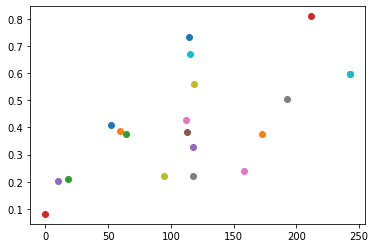

In [72]:
for key in CoDiff.keys():

  plt.scatter(CoDiff[key], smapes_RF_bin0[key])

print('Linear corr', np.corrcoef([CoDiff[key] for key in CoDiff.keys()], [smapes_RF_bin0[key] for key in CoDiff.keys()])[0,1])

print('Spearman corr', spearmanr([CoDiff[key] for key in CoDiff.keys()], [smapes_RF_bin0[key] for key in CoDiff.keys()]))

This is not very good - let's see if the issue is the fact that we are only using 50 features.

In [73]:
#Xlarge = X[:,::2] - just a reminder of the definition

bestmodel.fit(Xlarge, SFHs[:,0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [74]:
smapes_all_feat = []

for key in spectra.keys():
  print(key)
  spec = spectra[key]
  Xt = np.log10(spec[:,::2])
#  Xt = Xt[:,indices[:50]] No feature selection
  SFHpred = bestmodel.predict(Xt)
  smapes_all_feat.append(smape(SFHs[:,0],SFHpred))
  print(smape(SFHs[:,0],SFHpred))
a_all_feat = np.array(smapes_all_feat)

bc03_int_spec
0.8045717296900535
bc03_dustA_spec
0.4090591887688598
bc03_dustB_spec
0.392618338254973
bc03_dustC_spec
0.38071713949801345
fsps_int_spec
0.6007547267852509
fsps_dustA_spec
0.20991154273745544
fsps_dustB_spec
0.08056727973281995
fsps_dustC_spec
0.2031564914077187
fsps_neb_int_spec
0.6007547267852509
fsps_neb_dustA_spec
0.2710157641529199
fsps_neb_dustB_spec
0.26646189888953326
fsps_neb_dustC_spec
0.26562577603309484
bpass_int_spec
0.5103831890398628
bpass_dustA_spec
0.33712620823689354
bpass_dustB_spec
0.4045670878986096
bpass_dustC_spec
0.4511342950386886
bpass_sin_int_spec
0.38740293560105593
bpass_sin_dustA_spec
0.5833792576715203
bpass_sin_dustB_spec
0.705958723618678
bpass_sin_dustC_spec
0.7706048762987887


In [0]:
smapes_RF_all_feat_bin0 = dict(zip(spectra.keys(),a_all_feat))

Text(0, 0.5, 'With 50 features')

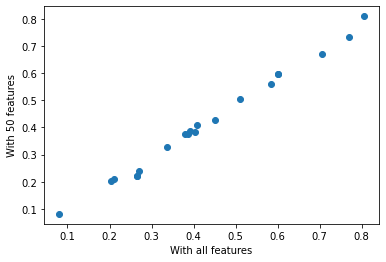

In [77]:
#We can check the SMAPEs calculated

plt.scatter(a_all_feat, a)
plt.xlabel('With all features')
plt.ylabel('With 50 features')

Linear corr 0.6404926359494141
Spearman corr SpearmanrResult(correlation=0.6177577125658389, pvalue=0.003701885886281471)


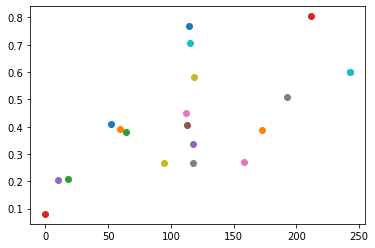

In [78]:
for key in CoDiff.keys():

  plt.scatter(CoDiff[key], smapes_RF_all_feat_bin0[key])

print('Linear corr', np.corrcoef([CoDiff[key] for key in CoDiff.keys()], [smapes_RF_all_feat_bin0[key] for key in CoDiff.keys()])[0,1])

print('Spearman corr', spearmanr([CoDiff[key] for key in CoDiff.keys()], [smapes_RF_all_feat_bin0[key] for key in CoDiff.keys()]))

Morale: **correlations for RF smapes for bin 0 and Covariance Differences are not that good**.

**Would the correlation improve if I used only the 50 features above?**

In [0]:
#Xlarge_lim is my original data set (all examples, 50 features)

In [0]:
scaler = StandardScaler()

In [0]:
Xn_best = scaler.fit_transform(Xlarge_lim) #normalize new matrix

In [0]:
EC_best = empirical_covariance(Xn_best, assume_centered=True)

In [83]:
#Calculate covariances; using empirical covariance for now

CovDiff_best = []

for el in spectra.keys():
  print(el) #same as enumerate(spectra.keys())
  spec = spectra[el]
  spec_best = spec[:,::2]
  spec_best = spec_best[:,indices[:50]]
  specn_best = scaler.fit_transform(spec_best) #normalizing using same prescription
  ECt_best = empirical_covariance(specn_best, assume_centered=True)
  print(np.linalg.norm(EC_best - ECt_best))
  CovDiff_best.append(np.linalg.norm(EC_best - ECt_best))

CD_best = np.array(CovDiff_best)

bc03_int_spec
3.227956952185864
bc03_dustA_spec
1.181592491747851
bc03_dustB_spec
1.0661399913864893
bc03_dustC_spec
1.013822635427252
fsps_int_spec
3.6707410241209857
fsps_dustA_spec
1.4890621666238475
fsps_dustB_spec
1.2792306697203881
fsps_dustC_spec
1.181902354642051
fsps_neb_int_spec
3.6707410241209857
fsps_neb_dustA_spec
2.187214119508506
fsps_neb_dustB_spec
1.7273566013824373
fsps_neb_dustC_spec
1.4760099881376125
bpass_int_spec
2.87272410548021
bpass_dustA_spec
2.7706712030715517
bpass_dustB_spec
2.682730554526344
bpass_dustC_spec
2.6385421472104094
bpass_sin_int_spec
2.7069301099353873
bpass_sin_dustA_spec
2.813848810874592
bpass_sin_dustB_spec
2.724635156487428
bpass_sin_dustC_spec
2.685763036899277


In [0]:
CoDiff_best = dict(zip(spectra.keys(),CD_best))

In [85]:
CoDiff_best

{'bc03_dustA_spec': 1.181592491747851,
 'bc03_dustB_spec': 1.0661399913864893,
 'bc03_dustC_spec': 1.013822635427252,
 'bc03_int_spec': 3.227956952185864,
 'bpass_dustA_spec': 2.7706712030715517,
 'bpass_dustB_spec': 2.682730554526344,
 'bpass_dustC_spec': 2.6385421472104094,
 'bpass_int_spec': 2.87272410548021,
 'bpass_sin_dustA_spec': 2.813848810874592,
 'bpass_sin_dustB_spec': 2.724635156487428,
 'bpass_sin_dustC_spec': 2.685763036899277,
 'bpass_sin_int_spec': 2.7069301099353873,
 'fsps_dustA_spec': 1.4890621666238475,
 'fsps_dustB_spec': 1.2792306697203881,
 'fsps_dustC_spec': 1.181902354642051,
 'fsps_int_spec': 3.6707410241209857,
 'fsps_neb_dustA_spec': 2.187214119508506,
 'fsps_neb_dustB_spec': 1.7273566013824373,
 'fsps_neb_dustC_spec': 1.4760099881376125,
 'fsps_neb_int_spec': 3.6707410241209857}

[[1.        0.6983512]
 [0.6983512 1.       ]]
SpearmanrResult(correlation=0.656884875846501, pvalue=0.0016524623117421234)


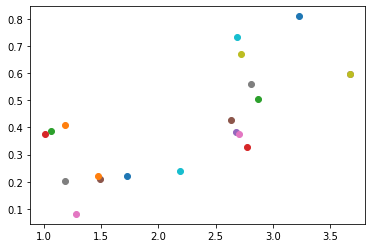

In [86]:
for key in CoDiff_best.keys():
  plt.scatter(CoDiff_best[key], smapes_RF_bin0[key])

print(np.corrcoef([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_RF_bin0[key] for key in CoDiff_best.keys()]))

print(spearmanr([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_RF_bin0[key] for key in CoDiff_best.keys()]))

We only see a modest improvement. It might be worth trying with another bin.

**Older stuff below (last update April 16)**


We can continue by predicting the other bins, and comparing to the results from the full calculation (with 1 every 2 features) below.


In [0]:
for i in range(1,8):
  scores = cross_validate(model, Xnew, transf_target(SFHs[sel,i]), cv = cv, verbose = 1, scoring=smape_scorer, return_train_score = True)
  print(scores)
  print(scores['test_score'].mean(), scores['test_score'].std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([1.93835664, 1.92603993, 1.88972139, 1.94275737]), 'score_time': array([0.00923896, 0.00854921, 0.00827384, 0.00815535]), 'test_score': array([-0.03529663, -0.03391354, -0.03649272, -0.03934138]), 'train_score': array([-0.01334339, -0.01313933, -0.01289258, -0.01392894])}
-0.036261068007006916 0.0019989363722062088


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([1.88396502, 1.87137604, 1.89276671, 1.86281133]), 'score_time': array([0.0082233 , 0.00829268, 0.00827098, 0.00851583]), 'test_score': array([-0.02674751, -0.03147618, -0.02958308, -0.02714191]), 'train_score': array([-0.01147822, -0.01128788, -0.01095183, -0.01097698])}
-0.028737172293272596 0.0019184182816218795


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([1.90012598, 1.86045814, 1.86323619, 1.85324502]), 'score_time': array([0.00814605, 0.0084269 , 0.00827909, 0.00839496]), 'test_score': array([-0.03389578, -0.02928534, -0.02641932, -0.02945783]), 'train_score': array([-0.01077088, -0.01080512, -0.01079749, -0.0103822 ])}
-0.029764568434397287 0.0026730743473871205


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([1.92806244, 1.90996647, 1.93305922, 1.92130113]), 'score_time': array([0.00839663, 0.00817728, 0.0081625 , 0.00822949]), 'test_score': array([-0.03871803, -0.03193566, -0.03599367, -0.03959401]), 'train_score': array([-0.01312837, -0.01392584, -0.01354527, -0.01284596])}
-0.03656034240877655 0.002981928023019271


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([2.0401938 , 1.98407197, 2.01211309, 1.99896145]), 'score_time': array([0.00841022, 0.00818419, 0.00824523, 0.0089345 ]), 'test_score': array([-0.04512847, -0.04026926, -0.04177732, -0.04180064]), 'train_score': array([-0.01536342, -0.01525373, -0.01483649, -0.01526969])}
-0.04224392221769683 0.0017772277270027537


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([2.1534481 , 2.11944151, 2.17510629, 2.1307745 ]), 'score_time': array([0.00829911, 0.0085597 , 0.00831842, 0.0083189 ]), 'test_score': array([-0.04591018, -0.04372264, -0.05003194, -0.04948544]), 'train_score': array([-0.01812926, -0.01820821, -0.01690747, -0.01795913])}
-0.04728755150975508 0.002596541802312426
{'fit_time': array([1.91237068, 1.93005466, 1.88873124, 1.88215041]), 'score_time': array([0.00830555, 0.0085516 , 0.00832367, 0.00819564]), 'test_score': array([-0.02889461, -0.03041601, -0.02799732, -0.02865169]), 'train_score': array([-0.01065063, -0.0101602 , -0.01080493, -0.01042334])}
-0.028989908418066562 0.000886352376277999


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.7s finished


Test scores are very similar to what we obtained using all features.

Ok, now onto SMAPE calculation for other simulated data sets.

In [0]:
bestmodel = RandomForestRegressor() #no parameter optimization because was found to be quite useless

In [0]:
bestmodel.fit(X[:,indices[:100]], transf_target(SFHs[:,0]))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
smapes = []
smapes_transf = []

for key in spectra.keys():
  print(key)
  spec = spectra[key]
  Xt = np.log10(spec[:,indices[:100]])
  SFHpred = bestmodel.predict(Xt)
  smapes.append(smape(SFHs[:,0],inv_transf_target(SFHpred)))
  smapes_transf.append(smape(transf_target(SFHs[:,0]),SFHpred))
  print(smape(transf_target(SFHs[:,0]),SFHpred))
  print(smape(SFHs[:,0],inv_transf_target(SFHpred)))
a = np.array(smapes)
a_transf = np.array(smapes_transf)

bc03_int_spec
0.142933989485378
0.7356913450981823
bc03_dustA_spec
0.06149836755072349
0.3453668826104374
bc03_dustB_spec
0.05820368080531717
0.32858211931516373
bc03_dustC_spec
0.05595158483180672
0.3172878448492339
fsps_int_spec
0.09497520850597337
0.539512083241499
fsps_dustA_spec
0.031989679720251046
0.20881628494342033
fsps_dustB_spec
0.012402464829416605
0.0823932714587918
fsps_dustC_spec
0.030885923987542568
0.2048241573666147
fsps_neb_int_spec
0.09497520850597337
0.539512083241499
fsps_neb_dustA_spec
0.05122634213107202
0.3692573964802727
fsps_neb_dustB_spec
0.0486822535488881
0.3526035423689554
fsps_neb_dustC_spec
0.0459330547954303
0.3326179686718879
bpass_int_spec
0.08824046946059078
0.5221512722024999
bpass_dustA_spec
0.04531630620627585
0.3094204853252237
bpass_dustB_spec
0.05116526366099316
0.35755400514892116
bpass_dustC_spec
0.05553670995913445
0.39227227188900016
bpass_sin_int_spec
0.06688031276896704
0.4223178847498894
bpass_sin_dustA_spec
0.07286643301881698
0.535494

In [0]:
smapes = dict(zip(spectra.keys(),a))
smapes_transf = dict(zip(spectra.keys(),a_transf))

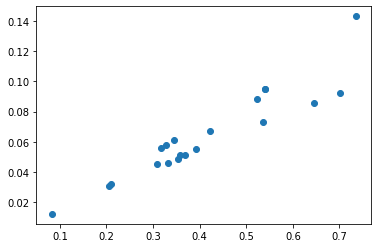

In [0]:
plt.scatter(smapes.values(), smapes_transf.values())

In [0]:
#Let's try to fit/predict using all features

In [0]:
bestmodel.fit(X, transf_target(SFHs[:,0]))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
smapes_all = []
smapes_all_transf = []

for key in spectra.keys():
  print(key)
  spec = spectra[key]
  Xt = np.log10(spec)
  SFHpred = bestmodel.predict(Xt)
  smapes_all.append(smape(SFHs[:,0],inv_transf_target(SFHpred)))
  smapes_all_transf.append(smape(transf_target(SFHs[:,0]),SFHpred))
  print(smape(transf_target(SFHs[:,0]),SFHpred))
  print(smape(SFHs[:,0],inv_transf_target(SFHpred)))
a_all = np.array(smapes_all)
a_all_transf = np.array(smapes_all_transf)

bc03_int_spec
0.1422186485898108
0.7368122693758115
bc03_dustA_spec
0.06213332538627149
0.35054647157739643
bc03_dustB_spec
0.05952727302294283
0.3359530945620964
bc03_dustC_spec
0.057793104584701986
0.327097905167263
fsps_int_spec
0.09462335541652699
0.541979005920028
fsps_dustA_spec
0.03206127898008184
0.20949083533105753
fsps_dustB_spec
0.012255241620160045
0.08159050340247266
fsps_dustC_spec
0.031087398043601527
0.2070953357475391
fsps_neb_int_spec
0.09462335541652699
0.541979005920028
fsps_neb_dustA_spec
0.04052880554250112
0.2791982584628996
fsps_neb_dustB_spec
0.04055974122187549
0.28175796638402034
fsps_neb_dustC_spec
0.04013172016408283
0.2791846912799451
bpass_int_spec
0.08783594031975336
0.5296376744986314
bpass_dustA_spec
0.043992981298176664
0.30311703657206013
bpass_dustB_spec
0.05049828037010698
0.35615844639992983
bpass_dustC_spec
0.054896061477611086
0.39050311366476614
bpass_sin_int_spec
0.07023661170161179
0.44537203786354
bpass_sin_dustA_spec
0.06957992849325595
0.5

In [0]:
smapes_all = dict(zip(spectra.keys(),a_all))
smapes_all_transf = dict(zip(spectra.keys(),a_all_transf))

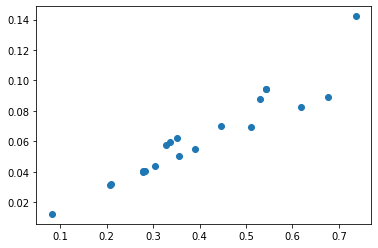

In [0]:
plt.scatter(smapes_all.values(), smapes_all_transf.values())

These are the covariances with all features

In [0]:
CoDiff = {'bc03_dustA_spec': 52.45952374852797,
 'bc03_dustB_spec': 59.47597890293729,
 'bc03_dustC_spec': 64.38199873143584,
 'bc03_int_spec': 211.80544648670522,
 'bpass_dustA_spec': 117.71157949665115,
 'bpass_dustB_spec': 113.07108853844643,
 'bpass_dustC_spec': 111.75957460428283,
 'bpass_int_spec': 192.2554817213096,
 'bpass_sin_dustA_spec': 118.74859273691484,
 'bpass_sin_dustB_spec': 115.45420489401205,
 'bpass_sin_dustC_spec': 114.77238582362264,
 'bpass_sin_int_spec': 172.80291177022934,
 'fsps_dustA_spec': 18.272998734688784,
 'fsps_dustB_spec': 0.0,
 'fsps_dustC_spec': 9.778511759224779,
 'fsps_int_spec': 242.48143483607842,
 'fsps_neb_dustA_spec': 158.68876953829346,
 'fsps_neb_dustB_spec': 117.35929923432032,
 'fsps_neb_dustC_spec': 94.77672170376769,
 'fsps_neb_int_spec': 242.48143483607842}

SMAPE correlation for this bin is actually worse when all features are used in computing the distance

[[1.        0.7757561]
 [0.7757561 1.       ]]
[[1.         0.72524903]
 [0.72524903 1.        ]]


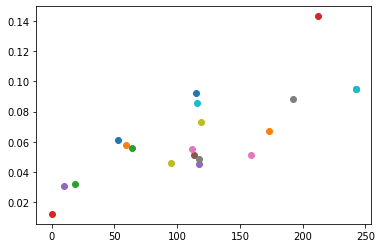

In [0]:
#scatter with SMAPES calculated on 100 features model

for key in CoDiff.keys():
  plt.scatter(CoDiff[key], smapes_transf[key])

print(np.corrcoef([CoDiff[key] for key in CoDiff.keys()], [smapes_transf[key] for key in CoDiff.keys()]))

#for key in CoDiff.keys():
#  plt.scatter(CoDiff[key], smapes[key])

print(np.corrcoef([CoDiff[key] for key in CoDiff.keys()], [smapes[key] for key in CoDiff.keys()]))

[[1.         0.75066867]
 [0.75066867 1.        ]]
[[1.         0.71227975]
 [0.71227975 1.        ]]


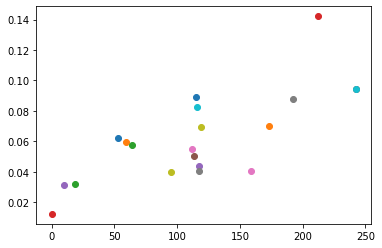

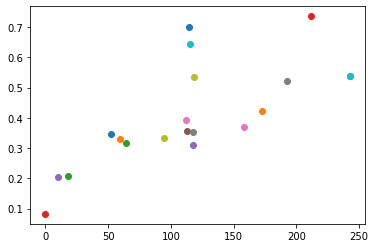

In [0]:
#scatter with SMAPES calculated on all features model

for key in CoDiff.keys():
  plt.scatter(CoDiff[key], smapes_all_transf[key])

print(np.corrcoef([CoDiff[key] for key in CoDiff.keys()], [smapes_all_transf[key] for key in CoDiff.keys()]))

plt.figure()

for key in CoDiff.keys():
  plt.scatter(CoDiff[key], smapes[key])

print(np.corrcoef([CoDiff[key] for key in CoDiff.keys()], [smapes_all[key] for key in CoDiff.keys()]))

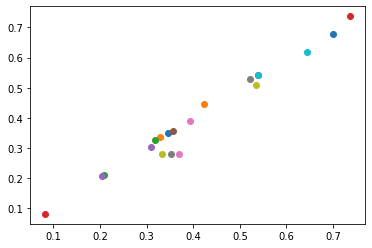

In [0]:
#comparison of SMAPES calculated on 100 features model vs all, same color code as above
for key in CoDiff.keys():
  plt.scatter(smapes[key],smapes_all[key])

Let's compute covariance or norm on 100 features only

In [0]:
indices[:100]

array([ 538,  537,  539,  535,  536,  540,  541,  534, 4442,  533, 4556,
        532,  543,  542, 4545,  530,   80,  531,  586,  431,  383,  397,
        547, 4037,  268,  553,  448,   15,  237,  421, 2092,  576,  395,
        452,  587,  769,  322,  127,  447,  298,  566,  578,  919,  747,
        375,  734,  250, 1041, 4585, 2245, 4150,  731,  216,  385, 4574,
        254,  827,  260,  570,  417,  550,   41,  363,  557,  888, 1033,
        429,  301,  927,  427, 4453,  876,  384,  433,  432, 4566,  251,
       4504,  456, 1266,  864,  729,  588, 4457,   22,  688,  317,   77,
        502,  434,   94, 4236,  529, 1087, 3380,  339,  549,  212,  253,
         21])

These are from SelectKBest, just for reference

array([ 74, 284, 285, 366, 367, 368, 369, 370, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 392,
       393, 402, 403, 404, 405, 417, 418, 419, 420, 424, 425, 426, 427,
       428, 429, 430, 431, 432, 433, 434, 435, 440, 441, 442, 443, 444,
       445, 446, 447, 448, 449, 450, 451, 452, 458, 459, 460, 519, 520,
       521, 522, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550,
       551, 552, 553, 583, 584, 585, 586, 587, 588])

In [0]:
from sklearn import feature_selection

In [0]:
filt1 = feature_selection.SelectKBest(feature_selection.f_regression, k=100)

In [0]:
ref_spec = spectra['fsps_dustB_spec']

In [0]:
filt1.fit(ref_spec, SFHs[:,0])

SelectKBest(k=100, score_func=<function f_regression at 0x7fc775ffcbf8>)

In [0]:
filt1.get_support(indices = True)

array([ 74, 284, 285, 366, 367, 368, 369, 370, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 392,
       393, 402, 403, 404, 405, 417, 418, 419, 420, 424, 425, 426, 427,
       428, 429, 430, 431, 432, 433, 434, 435, 440, 441, 442, 443, 444,
       445, 446, 447, 448, 449, 450, 451, 452, 458, 459, 460, 519, 520,
       521, 522, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550,
       551, 552, 553, 583, 584, 585, 586, 587, 588])

In [0]:
ref_best = ref_spec[:,filt1.get_support(indices = True)]


In [0]:
Xn_best = scaler.fit_transform(ref_best) #normalize new matrix

In [0]:
EC_best = empirical_covariance(Xn_best, assume_centered=True)

In [0]:
#Calculate covariances; using empirical covariance for now

CovDiff_best = []

for el in spectra.keys():
  print(el) #same as enumerate(spectra.keys())
  spec = spectra[el]
  spec_best = spec[:,filt1.get_support(indices = True)]
  specn_best = scaler.transform(spec_best) #normalizing using same prescription
  ECt_best = empirical_covariance(specn_best, assume_centered=True)
  print(np.linalg.norm(EC_best - ECt_best))
  CovDiff_best.append(np.linalg.norm(EC_best - ECt_best))

CD_best = np.array(CovDiff_best)

bc03_int_spec
462.19665009056956
bc03_dustA_spec
39.97605493430665
bc03_dustB_spec
33.92255371438859
bc03_dustC_spec
30.661535626268368
fsps_int_spec
353.6634919582977
fsps_dustA_spec
5.422719765783308
fsps_dustB_spec
0.0
fsps_dustC_spec
2.9813805514861937
fsps_neb_int_spec
353.6634919582977
fsps_neb_dustA_spec
31.437561359068162
fsps_neb_dustB_spec
18.453377670270783
fsps_neb_dustC_spec
12.393229019711
bpass_int_spec
597.3875270508765
bpass_dustA_spec
52.96713648274871
bpass_dustB_spec
44.71470001329763
bpass_dustC_spec
40.38523457230478
bpass_sin_int_spec
536.122915653703
bpass_sin_dustA_spec
45.410314874264735
bpass_sin_dustB_spec
38.70799647805462
bpass_sin_dustC_spec
35.347884078164036


In [0]:
CoDiff_best = dict(zip(spectra.keys(),CD_best))

In [0]:
CoDiff_best

{'bc03_dustA_spec': 39.97605493430665,
 'bc03_dustB_spec': 33.92255371438859,
 'bc03_dustC_spec': 30.661535626268368,
 'bc03_int_spec': 462.19665009056956,
 'bpass_dustA_spec': 52.96713648274871,
 'bpass_dustB_spec': 44.71470001329763,
 'bpass_dustC_spec': 40.38523457230478,
 'bpass_int_spec': 597.3875270508765,
 'bpass_sin_dustA_spec': 45.410314874264735,
 'bpass_sin_dustB_spec': 38.70799647805462,
 'bpass_sin_dustC_spec': 35.347884078164036,
 'bpass_sin_int_spec': 536.122915653703,
 'fsps_dustA_spec': 5.422719765783308,
 'fsps_dustB_spec': 0.0,
 'fsps_dustC_spec': 2.9813805514861937,
 'fsps_int_spec': 353.6634919582977,
 'fsps_neb_dustA_spec': 31.437561359068162,
 'fsps_neb_dustB_spec': 18.453377670270783,
 'fsps_neb_dustC_spec': 12.393229019711,
 'fsps_neb_int_spec': 353.6634919582977}

[[1.         0.68043229]
 [0.68043229 1.        ]]
[[1.         0.55689788]
 [0.55689788 1.        ]]


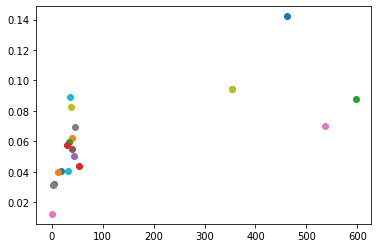

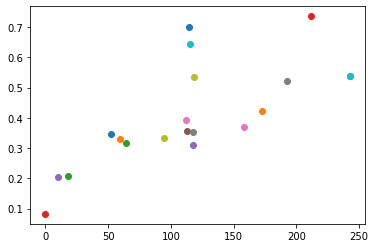

In [0]:
for key in CoDiff_best.keys():
  plt.scatter(CoDiff_best[key], smapes_all_transf[key])

print(np.corrcoef([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_all_transf[key] for key in CoDiff_best.keys()]))

plt.figure()
for key in CoDiff.keys():
  plt.scatter(CoDiff[key], smapes[key])

print(np.corrcoef([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_all[key] for key in CoDiff_best.keys()]))

Problem: is it possible that this is happening because the model has high variance and it acts up when generalized?

In [0]:
#Every 2 features

n_scores = cross_validate(model, Xnew, transf_target(target0), cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)

print(n_scores)
 
print(n_scores['test_score'].mean(),n_scores['test_score'].std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
{'fit_time': array([2.02752399, 1.95790362, 1.94582629, 1.95855904]), 'score_time': array([0.01002383, 0.00925756, 0.00842476, 0.00848913]), 'test_score': array([-0.04383986, -0.03186326, -0.04119095, -0.04307815]), 'train_score': array([-0.01456711, -0.01567081, -0.01491609, -0.01448049])}
-0.039993058689454714 0.004791770937120777


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.0s finished


In [0]:
parameters = {'max_depth':[5,10,20], \
              'max_features': [0.5,1.0], 'n_estimators':[100,200]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = smape_scorer, return_train_score = True, \
    verbose = 3, n_jobs = 4)
model.fit(Xnew, transf_target(target0))
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:  1.2min finished


Best params, best score: -0.0383 {'max_depth': 20, 'max_features': 1.0, 'n_estimators': 200}


In [0]:
res = pd.DataFrame(model.cv_results_)
res[['mean_train_score','mean_test_score','std_test_score','params','mean_fit_time']].sort_values('mean_test_score', ascending = False)#, sortedby = 'mean_test_score')

,mean_train_score,mean_test_score,std_test_score,params,mean_fit_time
11,-0.014885,-0.038315,0.002790,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 200}",12.046361
8,-0.014933,-0.038417,0.002458,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 100}",3.390673
10,-0.015057,-0.038827,0.002913,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 100}",6.200388
9,-0.014831,-0.038848,0.002860,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 200}",6.847061
5,-0.016691,-0.038921,0.002795,"{'max_depth': 10, 'max_features': 0.5, 'n_estimators': 200}",6.303844
6,-0.016583,-0.039002,0.003002,"{'max_depth': 10, 'max_features': 1.0, 'n_estimators': 100}",5.809772
7,-0.016588,-0.039077,0.002573,"{'max_depth': 10, 'max_features': 1.0, 'n_estimators': 200}",11.557096
4,-0.016761,-0.039105,0.002155,"{'max_depth': 10, 'max_features': 0.5, 'n_estimators': 100}",3.185681
0,-0.035878,-0.045132,0.001895,"{'max_depth': 5, 'max_features': 0.5, 'n_estimators': 100}",2.149162
3,-0.035398,-0.045240,0.002242,"{'max_depth': 5, 'max_features': 1.0, 'n_estimators': 200}",7.507545


In [0]:
bestmodel_lim = RandomForestRegressor(max_depth = 20, n_estimators = 200)

In [0]:
bestmodel_lim.fit(X[:,indices[:100]], transf_target(SFHs[:,0]))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
smapes_lim = []
smapes_lim_transf = []

for key in spectra.keys():
  print(key)
  spec = spectra[key]
  Xt = np.log10(spec[:,indices[:100]])
  SFHpred = bestmodel_lim.predict(Xt)
  smapes_lim.append(smape(SFHs[:,0],inv_transf_target(SFHpred)))
  smapes_lim_transf.append(smape(transf_target(SFHs[:,0]),SFHpred))
  print(smape(transf_target(SFHs[:,0]),SFHpred))
  print(smape(SFHs[:,0],inv_transf_target(SFHpred)))
a_lim = np.array(smapes_lim)
a_lim_transf = np.array(smapes_lim_transf)

bc03_int_spec
0.14321754807869636
0.7363558720409292
bc03_dustA_spec
0.06164427854021408
0.34561857554608755
bc03_dustB_spec
0.05864002767540529
0.33031505341161344
bc03_dustC_spec
0.056505162911128476
0.31982549814941147
fsps_int_spec
0.09381962647173733
0.5343169863827004
fsps_dustA_spec
0.03189093122693998
0.20813851188264543
fsps_dustB_spec
0.012274760987276418
0.08147898807864248
fsps_dustC_spec
0.030814358978814356
0.20479505753260643
fsps_neb_int_spec
0.09381962647173733
0.5343169863827004
fsps_neb_dustA_spec
0.04956848220724377
0.35779510791568675
fsps_neb_dustB_spec
0.047151134620103494
0.34185551267201997
fsps_neb_dustC_spec
0.04462121036830523
0.323087990703199
bpass_int_spec
0.08794779446421981
0.5199461801840388
bpass_dustA_spec
0.044087447464880226
0.3018703316816014
bpass_dustB_spec
0.05029984393690792
0.35247762782848846
bpass_dustC_spec
0.05498071372227683
0.3889839742141452
bpass_sin_int_spec
0.06584372224323404
0.41604973099803927
bpass_sin_dustA_spec
0.0712848571553

In [0]:
smapes_lim = dict(zip(spectra.keys(),a_lim))
smapes_lim_transf = dict(zip(spectra.keys(),a_lim_transf))

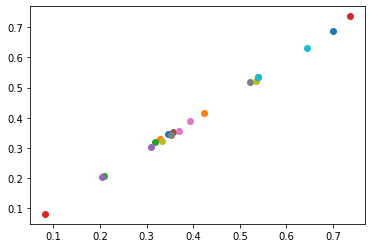

In [0]:
#comparison of SMAPES calculated on 100 features model and default params vs best 100 features model, 
for key in CoDiff.keys():
  plt.scatter(smapes[key],smapes_lim[key])

[[1.         0.65430191]
 [0.65430191 1.        ]]
[[1.         0.50303262]
 [0.50303262 1.        ]]


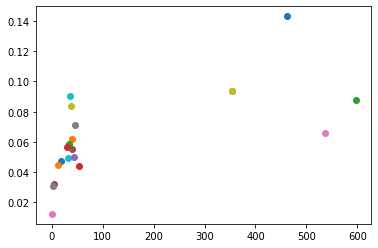

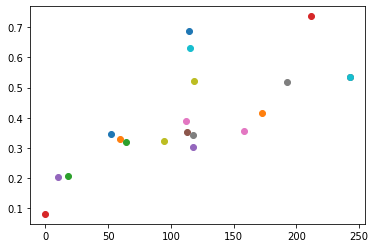

In [0]:
for key in CoDiff_best.keys():
  plt.scatter(CoDiff_best[key], smapes_lim_transf[key])

print(np.corrcoef([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_lim_transf[key] for key in CoDiff_best.keys()]))

plt.figure()
for key in CoDiff.keys():
  plt.scatter(CoDiff[key], smapes_lim[key])

print(np.corrcoef([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_lim[key] for key in CoDiff_best.keys()]))

[[1.         0.94633827]
 [0.94633827 1.        ]]
-0.49459685470239223


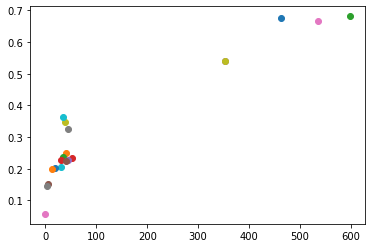

In [0]:
#Just checking in case I'm crazy

smapes_RF = {'bc03_dustA_spec': 0.24937033395796013,
 'bc03_dustB_spec': 0.23528570291639841,
 'bc03_dustC_spec': 0.22698198107701598,
 'bc03_int_spec': 0.6768479949305265,
 'bpass_dustA_spec': 0.23445830566093995,
 'bpass_dustB_spec': 0.22758600270595597,
 'bpass_dustC_spec': 0.22464032718642457,
 'bpass_int_spec': 0.6810513675788217,
 'bpass_sin_dustA_spec': 0.3236004371633811,
 'bpass_sin_dustB_spec': 0.3455423590850195,
 'bpass_sin_dustC_spec': 0.3614452757986425,
 'bpass_sin_int_spec': 0.6668520016397389,
 'fsps_dustA_spec': 0.15017376192736284,
 'fsps_dustB_spec': 0.05683577876967202,
 'fsps_dustC_spec': 0.14365922869303083,
 'fsps_int_spec': 0.5393774237322849,
 'fsps_neb_dustA_spec': 0.20594551912167294,
 'fsps_neb_dustB_spec': 0.20121278929696634,
 'fsps_neb_dustC_spec': 0.19966068074803198,
 'fsps_neb_int_spec': 0.5393774237322849}

for key in CoDiff_best.keys():
  plt.scatter(CoDiff_best[key], smapes_RF[key])

print(np.corrcoef([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_RF[key] for key in CoDiff_best.keys()]))

print(metrics.r2_score([CoDiff_best[key] for key in CoDiff_best.keys()], [smapes_RF[key] for key in CoDiff_best.keys()]))

In [0]:
codiff = np.array([CoDiff_best[key] for key in CoDiff_best.keys()])
s = np.array([smapes_RF[key] for key in CoDiff_best.keys()])

In [0]:
np.corrcoef(codiff, s)

array([[1.        , 0.94633827],
       [0.94633827, 1.        ]])

In [0]:
codiff

array([462.19665009,  39.97605493,  33.92255371,  30.66153563,
       353.66349196,   5.42271977,   0.        ,   2.98138055,
       353.66349196,  31.43756136,  18.45337767,  12.39322902,
       597.38752705,  52.96713648,  44.71470001,  40.38523457,
       536.12291565,  45.41031487,  38.70799648,  35.34788408])

Conclusion: go back to previous mess (in covariance notebook). Understand why after feature selection all the correlation goes to the faraway examples. Must be bad! Look into whether feature selection makes sense at all.

In [0]:
target1 = SFHs[sel,1]
scores1 = cross_validate(model, X[sel,::2], transf_target(SFHs[sel,1]), cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  36.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.5s remaining:    0.0s


[CV] ................................................. , total=  37.8s
[CV]  ................................................................
[CV] ................................................. , total=  39.2s
[CV]  ................................................................
[CV] ................................................. , total=  38.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.5min finished


In [0]:
scores1['test_score'].mean(), scores1['test_score'].std()

(-0.036716041831141764, 0.0018169854623511505)

What if I add the prediction from bin 0?

In [0]:
target1 = SFHs[sel,1]
scores1 = cross_validate(model, np.hstack((X[sel,::2], ypred0[:,None])), transf_target(SFHs[sel,1]), cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  35.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.1s remaining:    0.0s


[CV] ................................................. , total=  34.4s
[CV]  ................................................................
[CV] ................................................. , total=  34.7s
[CV]  ................................................................
[CV] ................................................. , total=  34.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min finished


In [0]:
scores1['test_score'].mean(), scores1['test_score'].std()

(-0.03735966807667751, 0.002474878496618499)

Meh.

In [0]:
ypred1 = cross_val_predict(model, np.hstack((X[sel,::2], ypred0[:,None])), transf_target(SFHs[sel,1]), cv = cv, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min finished


In [0]:
#Calculate smape on ypred1 with this technique

print(smape(target1,np.exp(ypred1)-5))

0.26260221247934934


Now predicting bin 2



In [0]:
scores2 = cross_validate(model, X[sel,::2], transf_target(SFHs[sel,2]), cv = cv, verbose = 2, scoring=smape_scorer, return_train_score = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  36.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.5s remaining:    0.0s


[CV] ................................................. , total=  36.5s
[CV]  ................................................................
[CV] ................................................. , total=  36.8s
[CV]  ................................................................
[CV] ................................................. , total=  36.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min finished


In [0]:
scores2['test_score'].mean(), scores2['test_score'].std()

(-0.032134351489936624, 0.0021773890069272683)

In [0]:
ypred2_nh = cross_val_predict(model, X[sel,::2], transf_target(SFHs[sel,2]), cv = cv, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min finished


In [0]:
#Calculate smape on ypred2 with this technique

print(smape(SFHs[sel,2],np.exp(ypred2_nh)-5))

0.2269148867351992


In [0]:
ypred2 = cross_val_predict(model, np.hstack((X[sel,::2], ypred0[:,None], ypred1[:,None])), transf_target(SFHs[sel,2]), cv = cv, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min finished


In [0]:
#Calculate smape on ypred2 with this technique

print(smape(SFHs[sel,2],np.exp(ypred2)-5))

0.23563332357675215


Let's continue with other bins

In [0]:
for i in range(3,8):
  scores = cross_validate(model, X[sel,::2], transf_target(SFHs[sel,i]), cv = cv, verbose = 1, scoring=smape_scorer, return_train_score = True)
  print(scores)
  print(scores['test_score'].mean(), scores['test_score'].std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([36.37846231, 36.55095267, 35.77699971, 36.21781731]), 'score_time': array([0.01305437, 0.0132401 , 0.01449227, 0.01327801]), 'test_score': array([-0.02825244, -0.03306814, -0.02692273, -0.02958474]), 'train_score': array([-0.01123362, -0.01115896, -0.01147261, -0.01108831])}
-0.02945701124019562 0.002287474276731809


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([37.53452229, 36.84534121, 37.64260459, 37.39108276]), 'score_time': array([0.01329255, 0.01389337, 0.013798  , 0.01315284]), 'test_score': array([-0.03602284, -0.03767614, -0.03130848, -0.04082055]), 'train_score': array([-0.01353108, -0.01374217, -0.01383522, -0.01285157])}
-0.03645700238544886 0.003435935526370351


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([39.55055547, 38.84752226, 38.48174906, 39.12675428]), 'score_time': array([0.01324081, 0.01425529, 0.01290631, 0.0137248 ]), 'test_score': array([-0.04659718, -0.04205893, -0.03948688, -0.03853919]), 'train_score': array([-0.01447874, -0.01542675, -0.01542087, -0.01648759])}
-0.041670545286615096 0.0031223522595166184


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([41.2729013 , 40.51789427, 42.06482434, 41.63677454]), 'score_time': array([0.0134933 , 0.01272178, 0.01389217, 0.01371002]), 'test_score': array([-0.05195256, -0.0488747 , -0.04475944, -0.05128239]), 'train_score': array([-0.01780224, -0.01771334, -0.01779342, -0.0172846 ])}
-0.049217274897815515 0.0028167403424060287
{'fit_time': array([37.86356378, 37.88724041, 38.0424614 , 37.98738217]), 'score_time': array([0.01402879, 0.01404166, 0.01299977, 0.01490116]), 'test_score': array([-0.03040106, -0.02819282, -0.02615629, -0.03071152]), 'train_score': array([-0.01109295, -0.01104813, -0.01071081, -0.01143651])}
-0.028865419907335575 0.0018410635278483204


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.5min finished


In [0]:
Notes: look at true vs ypred0 to judge predictions

Settle on percent error?

Choose two bins, derive errors



Unsupervised feature selection (one every two)

In [0]:
#Don't run

ypred = cross_val_predict(model, X[sel,::2], SFHs[sel,:], cv = cv, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min finished


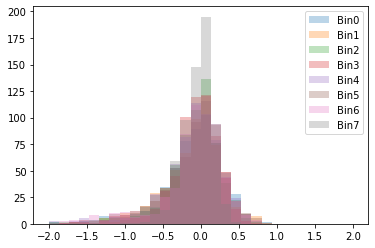

In [0]:
#Don't run

#distribution of residuals

for i in range(SFHs.shape[1]):
#  plt.figure()
  plt.hist((SFHs[sel,i] - ypred[:,i])/(SFHs[sel,i]+0.01), bins = 30, alpha = 0.3, range = [-2,2], label = 'Bin'+str(i))
plt.legend()

In [0]:
def smape(true,pred):
  return np.sum(np.abs(true-pred))/np.sum(true+pred)

In [0]:
def multioutputsmape(targets, pred):
  return np.mean(np.array([2 * smape(targets[i,:],pred[i,:]) for i in range(targets.shape[0])]))

In [0]:
smape_scorer = make_scorer(multioutputsmape, greater_is_better = False)

In [0]:
targets = SFHs[sel,:]

In [0]:
#Do not run; simple CV with every other feature and smape scorer below

#{'fit_time': array([41.71309137, 42.79233432, 41.62490797]),
# 'score_time': array([0.01293659, 0.01351094, 0.01302695]),
# 'test_score': array([-0.22774546, -0.23144261, -0.2346226 ]),
# 'train_score': array([-0.08610893, -0.08807034, -0.08678541])}

cv_results = cross_validate(model, X[sel,::2], targets,  cv = cv, scoring = smape_scorer, return_train_score=True);

In [0]:
cv_results

{'fit_time': array([41.71309137, 42.79233432, 41.62490797]),
 'score_time': array([0.01293659, 0.01351094, 0.01302695]),
 'test_score': array([-0.22774546, -0.23144261, -0.2346226 ]),
 'train_score': array([-0.08610893, -0.08807034, -0.08678541])}

Optimization, based on previous runs with other scorers. Problem is high variance

---

N_est = 200, tried sqrt features which wasn't good, can try with some fractions

In [0]:
parameters = {'max_depth':[20,40], \
              'max_features': [0.25,0.5,1.0], 'n_estimators':[100,200]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = smape_scorer, return_train_score = True, \
    verbose = 3, n_jobs = 4)
model.fit(X[sel,::2], targets)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed: 19.7min finished


Best params, best score: -0.2226 {'max_depth': 40, 'max_features': 0.5, 'n_estimators': 100}


In [0]:
res = pd.DataFrame(model.cv_results_)
res[['mean_train_score','mean_test_score','std_test_score','params','mean_fit_time']].sort_values('mean_test_score', ascending = False)#, sortedby = 'mean_test_score')

,mean_train_score,mean_test_score,std_test_score,params,mean_fit_time
8,-0.084193,-0.222640,0.005105,"{'max_depth': 40, 'max_features': 0.5, 'n_estimators': 100}",73.701877
9,-0.083530,-0.222999,0.004353,"{'max_depth': 40, 'max_features': 0.5, 'n_estimators': 200}",147.693908
1,-0.083451,-0.223163,0.005397,"{'max_depth': 20, 'max_features': 0.25, 'n_estimators': 200}",75.390342
3,-0.083550,-0.223483,0.003220,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 200}",156.666015
7,-0.083772,-0.223762,0.003972,"{'max_depth': 40, 'max_features': 0.25, 'n_estimators': 200}",74.566892
6,-0.084240,-0.223974,0.004448,"{'max_depth': 40, 'max_features': 0.25, 'n_estimators': 100}",37.815597
5,-0.083248,-0.224185,0.004105,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 200}",294.384429
11,-0.083739,-0.224732,0.004749,"{'max_depth': 40, 'max_features': 1.0, 'n_estimators': 200}",225.702444
2,-0.084624,-0.224987,0.002861,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 100}",76.434437
4,-0.084077,-0.225113,0.005023,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 100}",151.228841


Results show that improvement is minimal, barely significant. We can use n_features = 0.5 and n_est = 100 to be on the safe side (should confirm through nested CV)

## Cross validated feature selection ##

In [0]:
ntrials=5

glob_imp = np.zeros(sc_features.shape[1])

for i in range(ntrials):
        X_train, X_test, y_train, y_test = \
        train_test_split(sc_features, target, test_size=0.2, random_state=i) 
        model.fit(sc_features, target)
        importances = model.feature_importances_
        glob_imp+=importances
        
indices = np.argsort(glob_imp)[::-1]

        # Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature: %s, %d (%f)" % (f + 1, features.columns[indices[f]], indices[f], glob_imp[indices[f]]))

       

Shall we try GBMs and see if we can work on bias?

In [0]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor


In [0]:
model_B = MultiOutputRegressor(GradientBoostingRegressor()) #Did not work, too much RAM
#model_B = GradientBoostingRegressor()
cv_results = cross_validate(model_B, X[sel,::2], targets,  cv = cv, scoring = smape_scorer, return_train_score=True);

In [0]:
cv_results

{'fit_time': array([171.49835491, 177.16797352, 175.59178376]),
 'score_time': array([0.01924682, 0.02004647, 0.02006698]),
 'test_score': array([-0.23018453, -0.22122639, -0.2529532 ]),
 'train_score': array([-0.11661452, -0.11385335, -0.11041621])}

I would say no so won't pursue it further for now.

Let's look at performance on whole (rest of) data set using params n_split = 40, n_est = 100, max_features = 0.5



In [0]:
allindexes = np.arange(X.shape[0])

ind = allindexes[~np.isin(allindexes,sel)]

feat = X[ind,::2]

targ = SFHs[ind]

In [0]:
bestmodel = RandomForestRegressor(max_depth = 40, max_features = 0.5)

In [0]:
cv_results = cross_validate(bestmodel, feat, targ,  cv = cv, scoring = smape_scorer, return_train_score=True);


In [0]:
cv_results

#{'fit_time': array([324.81443143, 322.7449398 , 325.2868309 ]),
#'score_time': array([0.09922242, 0.10137129, 0.09655595]),
#'test_score': array([-0.17859983, -0.17917983, -0.17860528]),
#'train_score': array([-0.06672741, -0.06671317, -0.06716147])}

{'fit_time': array([324.81443143, 322.7449398 , 325.2868309 ]),
 'score_time': array([0.09922242, 0.10137129, 0.09655595]),
 'test_score': array([-0.17859983, -0.17917983, -0.17860528]),
 'train_score': array([-0.06672741, -0.06671317, -0.06716147])}

Not bad at all! SMAPE = 0.18 but let's remember to add noise.

In [0]:
#Will take some time (around 16 mins according to cross_validate) but good to take a look at SMAPEs

ypred = cross_val_predict(bestmodel, feat, targ, cv = cv, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.8min finished


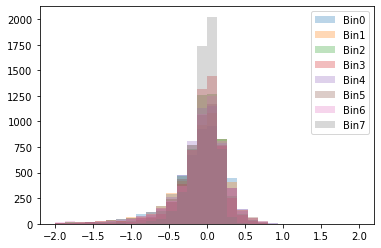

In [0]:
#distribution of residuals

for i in range(targ.shape[1]):
#  plt.figure()
  plt.hist((targ[:,i] - ypred[:,i])/(targ[:,i]+0.01), bins = 30, alpha = 0.3, range = [-2,2], label = 'Bin'+str(i))
plt.legend()

In [0]:
#

smapes = np.array([2 * smape(targ[i,:],ypred[i,:]) for i in range(targ.shape[0])])

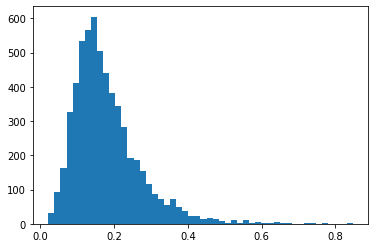

In [0]:
plt.hist(smapes, bins = 50);

In [0]:
from scipy import stats

In [0]:
stats.describe(smapes)

DescribeResult(nobs=5851, minmax=(0.021497441137042533, 0.8465597479796513), mean=0.17867202868650603, variance=0.008090173095306819, skewness=1.5633976670425058, kurtosis=4.20434101985343)

In [0]:
np.median(smapes)

0.16012715050675985

**Next step: train model on all data. Apply to other sims. Compare with EMDs and SOM-based distances. Exciting!**

In [0]:
bestmodel.fit(X[:,::2], SFHs)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
mediansmapes = []

for spec in spectra.values():
  Xt = np.log10(spec[:,::2])
  SFHpred = bestmodel.predict(Xt)
  smapes = np.array([2 * smape(SFHs[i,:],SFHpred[i,:]) for i in range(SFHs.shape[0])])
  mediansmapes.append(np.median(smapes))

a = np.array(mediansmapes)

In [0]:
smapes = dict(zip(spectra.keys(),a))

In [0]:
smapes

{'bc03_dustA_spec': 0.24937033395796013,
 'bc03_dustB_spec': 0.23528570291639841,
 'bc03_dustC_spec': 0.22698198107701598,
 'bc03_int_spec': 0.6768479949305265,
 'bpass_dustA_spec': 0.23445830566093995,
 'bpass_dustB_spec': 0.22758600270595597,
 'bpass_dustC_spec': 0.22464032718642457,
 'bpass_int_spec': 0.6810513675788217,
 'bpass_sin_dustA_spec': 0.3236004371633811,
 'bpass_sin_dustB_spec': 0.3455423590850195,
 'bpass_sin_dustC_spec': 0.3614452757986425,
 'bpass_sin_int_spec': 0.6668520016397389,
 'fsps_dustA_spec': 0.15017376192736284,
 'fsps_dustB_spec': 0.05683577876967202,
 'fsps_dustC_spec': 0.14365922869303083,
 'fsps_int_spec': 0.5393774237322849,
 'fsps_neb_dustA_spec': 0.20594551912167294,
 'fsps_neb_dustB_spec': 0.20121278929696634,
 'fsps_neb_dustC_spec': 0.19966068074803198,
 'fsps_neb_int_spec': 0.5393774237322849}

In [0]:
filename = 'ref_fsps_dustB_spec_EMD.txt'
with filename open as f:
  d = f.readlines()
#dist = np.genfromtxt('My Drive/'+filename)

SyntaxError: ignored

Previous optimization runs below

In [0]:
#Do not run: cv with r2 score

#Results

#{'fit_time': array([53.27171755, 52.12764168, 53.28606129, 53.26166272]),
# 'score_time': array([0.01601958, 0.0146246 , 0.01494336, 0.01519322]),
# 'test_score': array([0.81165198, 0.87030236, 0.86739246, 0.88866265]),
# 'train_score': array([0.98043601, 0.97968621, 0.98108432, 0.97960353])}

cv = KFold(shuffle = True, n_splits=4)

cv_results = cross_validate(model, X[sel,::2], targets,  cv = cv, return_train_score=True);

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

In [0]:
cv_results

{'fit_time': array([53.27171755, 52.12764168, 53.28606129, 53.26166272]),
 'score_time': array([0.01601958, 0.0146246 , 0.01494336, 0.01519322]),
 'test_score': array([0.81165198, 0.87030236, 0.86739246, 0.88866265]),
 'train_score': array([0.98043601, 0.97968621, 0.98108432, 0.97960353])}

In [0]:
#Do not run, CV with neg med abs err

#{'fit_time': array([54.1445663 , 52.86333227, 53.88323212, 54.79486084]),
# 'score_time': array([0.01488876, 0.01699281, 0.01373649, 0.01461649]),
# 'test_score': array([-0.40613118, -0.46373731, -0.40043115, -0.37756717]),
# 'train_score': array([-0.14555735, -0.14599829, -0.15410287, -0.1604189 ])}

cv_results = cross_validate(model, X[sel,::2], targets,  cv = cv, scoring = 'neg_median_absolute_error', return_train_score=True);

In [0]:
cv_results

{'fit_time': array([54.1445663 , 52.86333227, 53.88323212, 54.79486084]),
 'score_time': array([0.01488876, 0.01699281, 0.01373649, 0.01461649]),
 'test_score': array([-0.40613118, -0.46373731, -0.40043115, -0.37756717]),
 'train_score': array([-0.14555735, -0.14599829, -0.15410287, -0.1604189 ])}

In [0]:
parameters = {'max_depth':[20,40], \
              'max_features': [0.25,0.5,1.0], 'n_estimators':[100,200]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = smape_scorer, return_train_score = True, \
    verbose = 2, n_jobs = 4)
model.fit(X[sel,::2], targets)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
#print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [0]:
parameters = {'max_depth':[8,12,20], \
              'max_features': ['auto','sqrt'], 'n_estimators':[100,200]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = 'neg_median_absolute_error', return_train_score = True, \
    verbose = 2, n_jobs = 4)
start = time.time()
model.fit(X[sel,::2], targets)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 19.4min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 25.9min finished


Best params, best score: -0.3992 {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}
Time per model (s): 35.4968


In [0]:
model.cv_results_

{'mean_fit_time': array([142.08366597, 281.02833021,   3.62773597,   7.20128304,
        175.92155129, 354.93943012,   4.40083194,   8.71038419,
        185.85670829, 371.20518613,   4.79526126,   8.64055562]),
 'mean_score_time': array([0.03765577, 0.06617844, 0.04712707, 0.07398534, 0.0460602 ,
        0.08255142, 0.04830873, 0.08664465, 0.04365295, 0.09512132,
        0.05063039, 0.0543642 ]),
 'mean_test_score': array([-0.44103841, -0.44494769, -0.48930196, -0.48785785, -0.40170052,
        -0.40611576, -0.44119677, -0.44180372, -0.4014455 , -0.39918231,
        -0.44515741, -0.43259462]),
 'mean_train_score': array([-0.31310871, -0.31072779, -0.35199807, -0.35286472, -0.17899306,
        -0.18147997, -0.20830142, -0.20607399, -0.14763381, -0.14861138,
        -0.16305295, -0.1631004 ]),
 'param_max_depth': masked_array(data=[8, 8, 8, 8, 12, 12, 12, 12, 20, 20, 20, 20],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fal

In [0]:
a = pd.DataFrame(model.cv_results_)
a[['mean_train_score','mean_test_score','params',mean_fit_time]].sort_values('mean_test_score', ascending = False)#, sortedby = 'mean_test_score')

NameError: ignored

In [0]:
parameters2 = {'max_depth':[20,30,40], \
              'max_features': ['auto'], 'n_estimators':[200,500]}

nmodels2 = np.product([len(el) for el in parameters2.values()])

model2 = GridSearchCV(RandomForestRegressor(), parameters2, cv = cv, \
                     scoring = 'neg_median_absolute_error', return_train_score = True, \
    verbose = 2, n_jobs = 4)
start = time.time()
model2.fit(X[sel,::2], targets)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model2.best_score_), model2.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels2*4)))


Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 64.9min finished


Best params, best score: -0.3959 {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200}
Time per model (s): 168.6162


In [0]:
b = pd.DataFrame(model2.cv_results_)
b[['mean_train_score','mean_test_score','params','mean_fit_time']].sort_values('mean_test_score', ascending = False)#, sortedby = 'mean_test_score')

,mean_train_score,mean_test_score,params,mean_fit_time
2,-0.146802,-0.395946,"{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200}",369.994167
4,-0.146782,-0.400436,"{'max_depth': 40, 'max_features': 'auto', 'n_estimators': 200}",372.839408
3,-0.146567,-0.400541,"{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 500}",926.055208
1,-0.147896,-0.401356,"{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}",923.513032
0,-0.148202,-0.401552,"{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}",371.707079
5,-0.147294,-0.402877,"{'max_depth': 40, 'max_features': 'auto', 'n_estimators': 500}",919.583136


In [0]:
smape_scorer = make_scorer(multioutputsmape, greater_is_better = False)

NameError: ignored

In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [0]:
#This helps visualize the training vs the test. Will help us visualize and see what would happen if we use more data or if 
#the data has plateaued. 

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring, verbose = 2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from cross-validation")

    plt.legend(loc="best")
    return plt

In [0]:
a.tr